# Cornerstone Project - Inferential Analysis
### Zillow's Zestimate Error Prediction

Kaggle link: https://www.kaggle.com/c/zillow-prize-1/data

#### Project Overview

The problem is first raised by Zillow on Kaggle. Zillow, a home price valuation company, provides the datasets for people to analyze and start with. The goa is to predict of Zillow's log errors, which is defined as: log error = log(Zestimate) – log(Sale Price). Zestimates, like the name indicates, are values of home estimated by Zillow based on statistical and machine learning models. 

In other words, this project is not to predict home value for Zillow, but to analyze how wrong Zellow's predictions are. The project evaluation is based on the Mean Absolute Error between the predicted log error (predicted error by the project) and the actual log error (Zillow’s prediction error).

What adds to the complexity is that participants are asked to predict 3 time points: October 2017 (201710), November 2017 (201711), and December 2017 (201712). Thus it will involve time series.

#### Target Audience
The output will help Zillow to identify and reduce prediction errors, and provide more accurate home value estimations.

#### File Descriptions
There are four datasets provided by Zillow of two kinds. The properties data contains all the home features of the properties, and training data contains all the transaction information of each year. The properties are from three counties: Los Angeles, Orange, and Ventura, CA.

properties_2016.csv – all the properties with their home features for 2016
properties_2017.csv – all the properties with their home features for 2017
train_2016.csv – the training set with transactions from 1/1/2016 to 12/31/2016
train_2017.csv – the training set with transactions from 1/1/2017 to 9/15/2017

The properties datasets provide 58 features, such as the floor plan, building class type, garage size, pool count, year build, location, tax amount, etc. There are plenty of nulls in some columns.

---
## 1. Importing & Merging Data

#### Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
color = sns.color_palette()

import warnings
warnings.filterwarnings('ignore')

#### Set data directory

In [2]:
data_dir = '/Users/Zhang/Downloads/Zillow_Data/'

#### Import data

In [3]:
properties_2016 = pd.read_csv(data_dir + 'properties_2016.csv')
properties_2017 = pd.read_csv(data_dir + 'properties_2017.csv')
train_2016 = pd.read_csv(data_dir + 'train_2016.csv')
train_2017 = pd.read_csv(data_dir + 'train_2017.csv')

#### Test if rows in each dataset have unique parcelid

In [4]:
print('# of parcelid\'s in properties_2016.csv: ' + str(len(properties_2016.parcelid)))
print('# of parcelid\'s in properties_2017.csv: ' + str(len(properties_2017.parcelid)))
print('# of unique parcelid\'s in properties_2016.csv: ' + str(len(set(properties_2016.parcelid))))
print('# of unique parcelid\'s in properties_2017.csv: ' + str(len(set(properties_2017.parcelid))))

print('\n# of parcelid\'s in train_2016.csv: ' + str(len(train_2016.parcelid)))
print('# of parcelid\'s in train_2017.csv: ' + str(len(train_2017.parcelid)))
print('# of unique parcelid\'s in train_2016.csv: ' + str(len(set(train_2016.parcelid))))
print('# of unique parcelid\'s in train_2017.csv: ' + str(len(set(train_2017.parcelid))))

# of parcelid's in properties_2016.csv: 2985217
# of parcelid's in properties_2017.csv: 2985217
# of unique parcelid's in properties_2016.csv: 2985217
# of unique parcelid's in properties_2017.csv: 2985217

# of parcelid's in train_2016.csv: 90275
# of parcelid's in train_2017.csv: 77613
# of unique parcelid's in train_2016.csv: 90150
# of unique parcelid's in train_2017.csv: 77414


The parcelid of each row in Properties is unique.
Rows in Train share same parcelid, because some properties are sold multiple times in one year.

#### Test whether the parcelid's in Properties_2016 and Properties_2017 are the same

In [5]:
test = pd.concat([properties_2016, properties_2017])
test.sort_index(inplace=True)

sub1=test.index[:-1].tolist()
sub2=test.index[1:].tolist()

mask = [sub1[i] != sub2[i] for i in range(len(sub1))]
mask.append(True)

- The # of unique parcelid in the joint file from two Properties datasets is 2985217
- Thus the two datasets have same set of parcelid.
- In other words, the data are from the same properties.

#### Merge the Properties data w/ Train data of respective year

In [6]:
merged_2016 = train_2016.join(properties_2016.set_index('parcelid'), on='parcelid')
merged_2017 = train_2017.join(properties_2017.set_index('parcelid'), on='parcelid')

print('- The merged 2016 dataset has ' + str(merged_2016.shape[0]) + ' rows and ' + \
      str(merged_2016.shape[1]) + ' columns')
print('- The merged 2017 dataset has ' + str(merged_2017.shape[0]) + ' rows and ' + \
      str(merged_2017.shape[1]) + ' columns')

- The merged 2016 dataset has 90275 rows and 60 columns
- The merged 2017 dataset has 77613 rows and 60 columns


#### Concatenate the merged data

In [7]:
merged = pd.concat([merged_2016, merged_2017])
merged.transactiondate = pd.to_datetime(merged.transactiondate)
merged.sort_values(by=['transactiondate'], inplace=True)
merged.to_csv(data_dir + 'merged.csv')

print('There are ' + str(len(merged.parcelid)) + ' transactions associated w/ ' \
      + str(len(set(merged.parcelid))) + ' properties from 1/1/2016 to 9/25/2017.\n')

There are 167888 transactions associated w/ 165210 properties from 1/1/2016 to 9/25/2017.



---
## 2. Data Preparation

#### Data types of the feature columns

In [8]:
types = merged.dtypes
print(types)

parcelid                                 int64
logerror                               float64
transactiondate                 datetime64[ns]
airconditioningtypeid                  float64
architecturalstyletypeid               float64
basementsqft                           float64
bathroomcnt                            float64
bedroomcnt                             float64
buildingclasstypeid                    float64
buildingqualitytypeid                  float64
calculatedbathnbr                      float64
decktypeid                             float64
finishedfloor1squarefeet               float64
calculatedfinishedsquarefeet           float64
finishedsquarefeet12                   float64
finishedsquarefeet13                   float64
finishedsquarefeet15                   float64
finishedsquarefeet50                   float64
finishedsquarefeet6                    float64
fips                                   float64
fireplacecnt                           float64
fullbathcnt  

- Most of the columns are float. Some columns are strings. (object type)
- Some int/float columns should be treated as strings (e.g. the ones ending w/ "id").

#### Convert categorical features from float to string format

In [9]:
# Find columns containing 'id'
str_cols = [col for col in merged.columns if 'id' in col]

# Add other columns looking like string
str_cols.append('fips')
str_cols.append('rawcensustractandblock')
str_cols.append('censustractandblock')

# Create a copy of merged data
merged2 = merged.copy()

# Change the string columns to string
merged2[str_cols] = merged2[str_cols].astype(str)

#### Identify nulls

In [10]:
# Print first 5 rows of data
merged.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


In [11]:
merged.describe()

,parcelid,logerror,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock
count,1.678880e+05,167888.000000,53788.000000,468.000000,93.000000,167854.000000,167854.000000,31.000000,107173.000000,166056.000000,...,165.000000,166828.000000,38169.000000,1.673590e+05,1.678520e+05,167854.000000,1.678510e+05,167843.000000,4683.000000,1.670020e+05
mean,1.299536e+07,0.013906,1.814345,7.299145,695.376344,2.288265,3.041739,3.967742,6.015461,2.312542,...,271.260606,1968.569311,1.437764,1.843460e+05,4.726833e+05,2015.462181,2.888805e+05,5989.515575,13.827247,6.049390e+13
std,3.016071e+06,0.165706,2.970239,2.719633,583.952144,1.000835,1.149134,0.179605,1.882799,0.977808,...,293.611447,23.777202,0.544508,2.192841e+05,6.028372e+05,0.498569,4.456451e+05,7214.731946,2.421658,1.054137e+12
min,1.071174e+07,-4.655420,1.000000,2.000000,38.000000,0.000000,0.000000,3.000000,1.000000,1.000000,...,12.000000,1824.000000,1.000000,4.400000e+01,2.200000e+01,2015.000000,2.200000e+01,19.920000,3.000000,6.037101e+13
25%,1.154899e+07,-0.025300,1.000000,7.000000,280.000000,2.000000,2.000000,4.000000,4.000000,2.000000,...,88.000000,1953.000000,1.000000,8.256800e+04,2.026522e+05,2015.000000,8.373000e+04,2798.070000,13.000000,6.037312e+13
50%,1.254060e+07,0.006000,1.000000,7.000000,588.000000,2.000000,3.000000,4.000000,7.000000,2.000000,...,160.000000,1970.000000,1.000000,1.340510e+05,3.500000e+05,2015.000000,1.977760e+05,4501.040000,14.000000,6.037604e+13
75%,1.421930e+07,0.039200,1.000000,7.000000,819.000000,3.000000,4.000000,4.000000,7.000000,3.000000,...,320.000000,1987.000000,2.000000,2.142570e+05,5.540020e+05,2016.000000,3.553340e+05,6914.165000,15.000000,6.059042e+13
max,1.676893e+08,5.262999,13.000000,21.000000,3560.000000,20.000000,16.000000,4.000000,12.000000,20.000000,...,1366.000000,2016.000000,6.000000,1.142179e+07,4.906124e+07,2016.000000,4.895220e+07,586639.300000,99.000000,4.830301e+14


Some columns have too few non-nulls. Later we will explore these columns first. If they are not important, we will remove them.

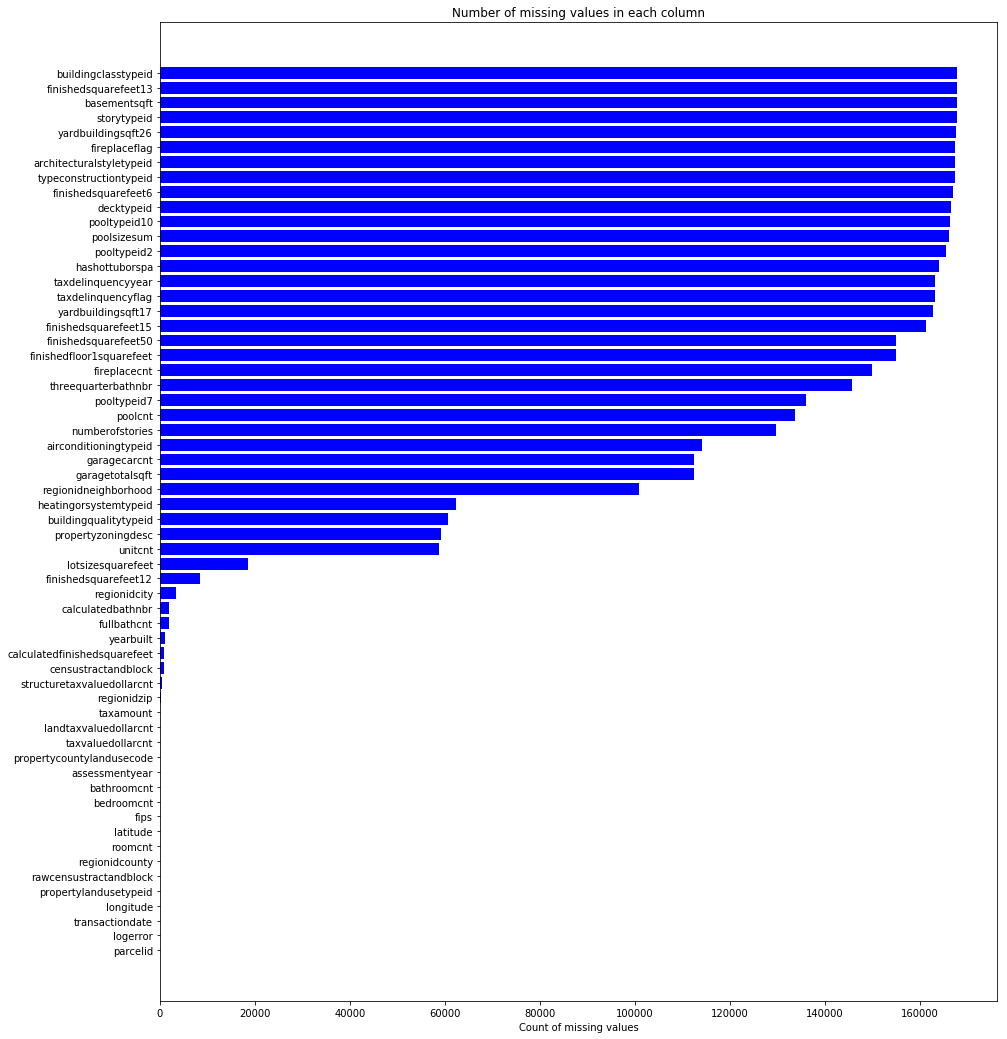

In [12]:
missing_df = merged.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
#missing_df = missing_df.ix[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(15,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

----
## 3. Exploratory Analysis

### Logerror

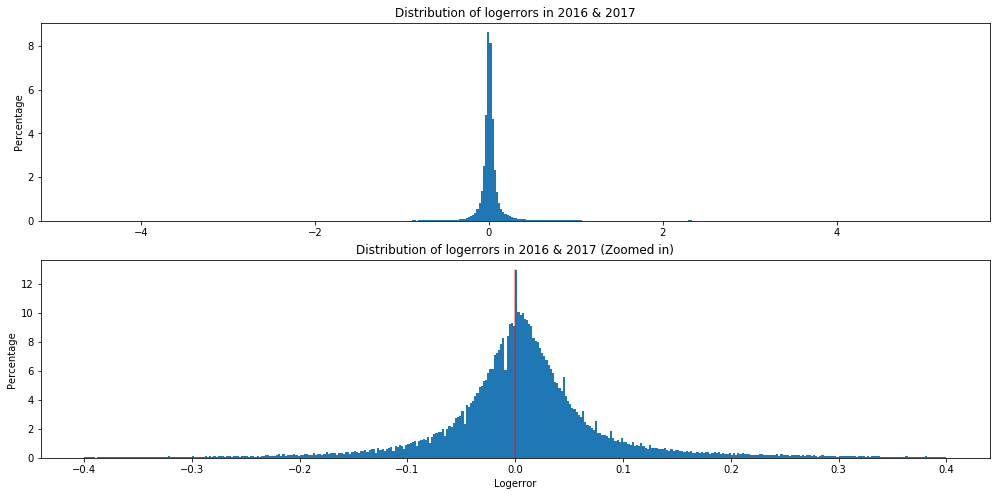

99% of logerrors are between (-0.49, 0.76), but there are outliers, such as max = 5.26 & min = -4.66


In [13]:
# Description of logerror
le_des = merged.logerror.describe()

# Find the range of 99% of logerrors
range_99 = np.percentile(merged.logerror, [.5, 99.5])

# Bins of histogram
bins = 400 # ~= int(np.sqrt(len(merged)))

# Histogram of logerrors
plt.figure(figsize=(17, 8))
plt.subplot(2, 1, 1)
plt.hist(merged.logerror, bins=bins, normed=True)
plt.xlabel('')
plt.ylabel('Percentage')
plt.title('Distribution of logerrors in 2016 & 2017')

# Zoomed histogram of logerrors
plt.subplot(2, 1, 2)
plt.hist(merged.logerror, bins=bins, normed=True, range=[-.4, .4])
plt.plot([0, 0], [0, 13], color='r', alpha=.5)
plt.xlabel('Logerror')
plt.ylabel('Percentage')
plt.title('Distribution of logerrors in 2016 & 2017 (Zoomed in)')

plt.show()

print('99% of logerrors are between (' + str(round(range_99[0], 2)) + ', ' + \
      str(round(range_99[1], 2)) + '), but there are outliers, such as max = ' + \
      str(round(le_des['max'], 2)) + ' & min = ' + str(round(le_des['min'], 2)))


- The logerrors are highly concentrated around zero. Most of them are between -.2 and .2.
- The distribution is slightly skewed to the right and has a faintly positive mean.
- The distribution has single peak and thin tails.

### Transaction date

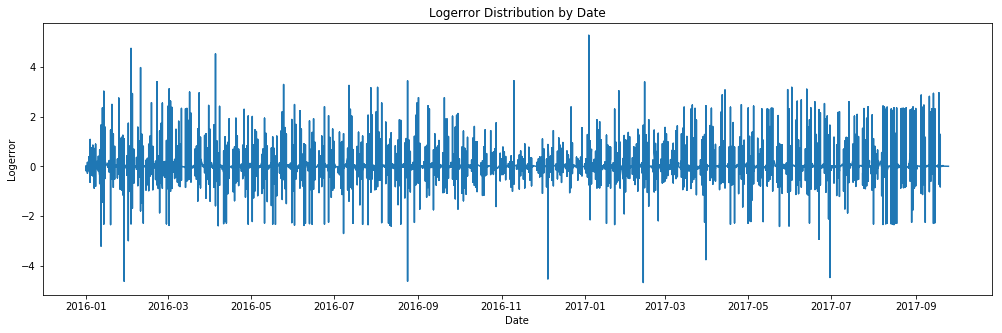

In [14]:
plt.figure(figsize=(17, 5))

plt.plot(merged.transactiondate, merged.logerror)
plt.xlabel('Date')
plt.ylabel('Logerror')
plt.title('Logerror Distribution by Date')

plt.show()

The variance between Oct and Dec shrinks due to decline of transactions. We will probably see similar trend in 2017-11 to 2018-1.

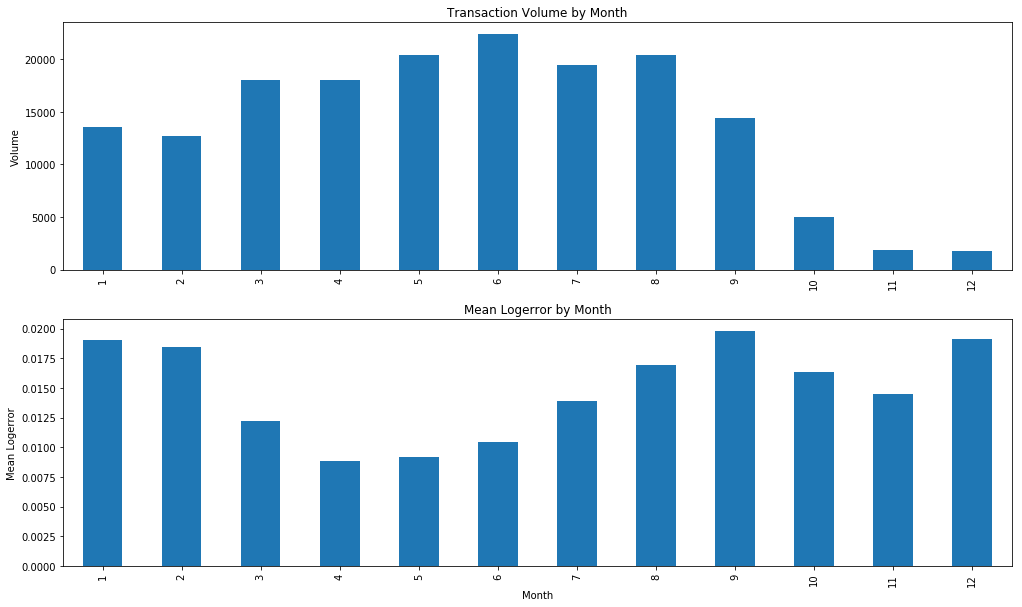

In [15]:
plt.figure(figsize=(17, 10))

plt.subplot('211')
merged['logerror'].groupby(merged["transactiondate"].dt.month).count().plot(kind="bar")
plt.xlabel('')
plt.ylabel('Volume')
plt.title('Transaction Volume by Month')

plt.subplot('212')
merged['logerror'].groupby(merged["transactiondate"].dt.month).mean().plot(kind="bar")
plt.xlabel('Month')
plt.ylabel('Mean Logerror')
plt.title('Mean Logerror by Month')

plt.show()

Transaction volumes fell in holiday season (Oct-Dec). Homeowners and buyers are active in summer (Jun-Aug).
The average logerror is larger in months w/ less transactions (Sep to Feb)

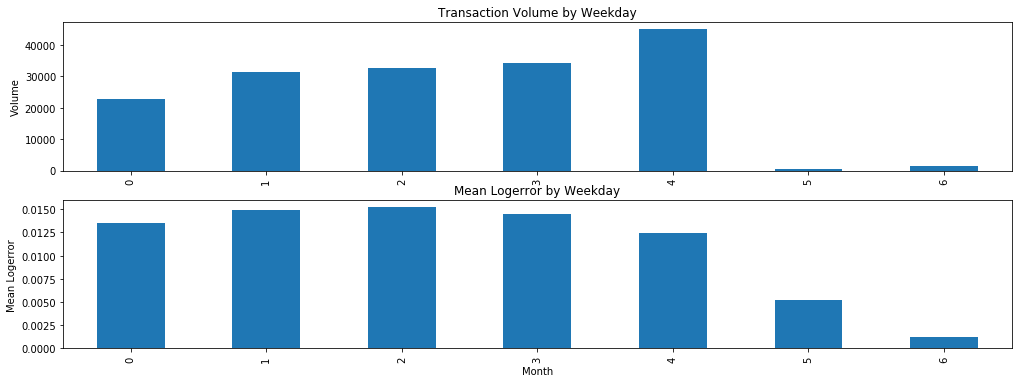

In [16]:
plt.figure(figsize=(17, 6))

plt.subplot('211')
merged['logerror'].groupby(merged["transactiondate"].dt.weekday).count().plot(kind="bar")
plt.xlabel('')
plt.ylabel('Volume')
plt.title('Transaction Volume by Weekday')

plt.subplot('212')
merged['logerror'].groupby(merged["transactiondate"].dt.weekday).mean().plot(kind="bar")
plt.xlabel('Month')
plt.ylabel('Mean Logerror')
plt.title('Mean Logerror by Weekday')

plt.show()

Most transactions are made in weekdays, very little volume during weekends.
Despite of the minimal volume during weekends, the logerrors are much lower.
There is no significant difference of logerror among the weekdays.

### Features Analysis


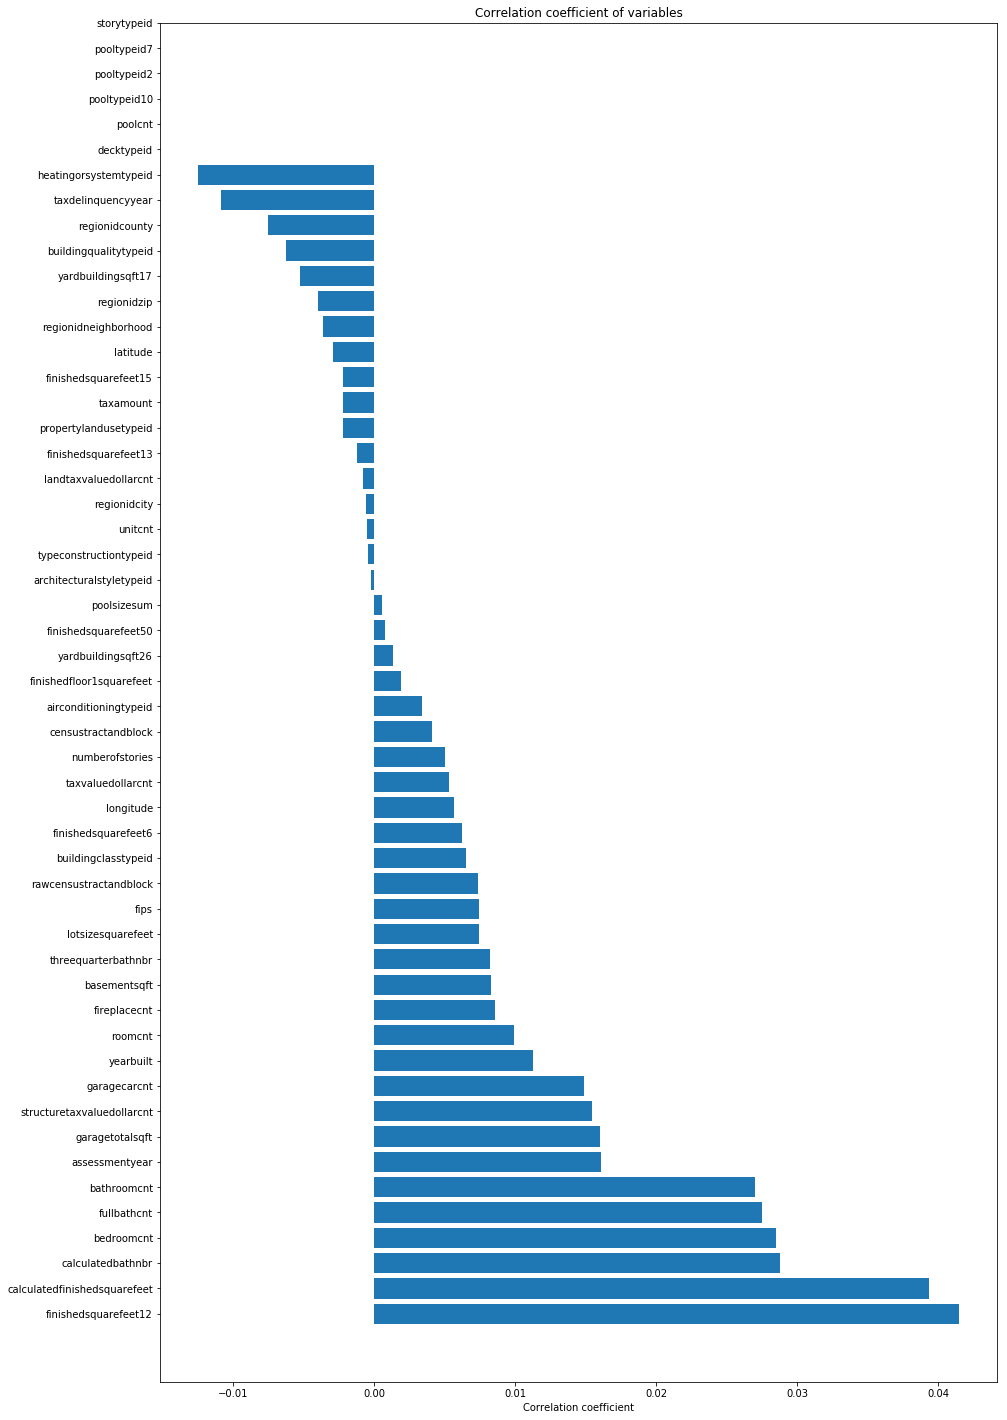

In [17]:
# Let us just impute the missing values with mean values to compute correlation coefficients #
mean_values = merged.mean(axis=0)
train_df_new = merged.fillna(mean_values, inplace=False)

# Now let us look at the correlation coefficient of each of these variables #
x_cols = [col for col in train_df_new.columns if col not in ['logerror'] if train_df_new[col].dtype=='float64']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train_df_new[col].values, train_df_new.logerror.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values}).sort_values(by='corr_values', ascending=False)
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(15,25))
rects = ax.barh(ind, np.array(corr_df.corr_values.values))
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of variables")

plt.show()

#### Take a look at the logerror distribution of features w/ high correlation coefficient

In [18]:
# Remove nulls
corr_df_nonull = corr_df[corr_df.corr_values.notnull()].set_index('col_labels')

# Calculate absolute values of correlation coefficients
corr_df_abs = corr_df_nonull.abs().sort_values(by='corr_values', ascending=False)

# Take the features with high correlation coefficients
corr_df_new = corr_df_abs[corr_df_abs.corr_values > .01]

corr_df_new

,corr_values
col_labels,
finishedsquarefeet12,0.041471
calculatedfinishedsquarefeet,0.039344
calculatedbathnbr,0.028814
bedroomcnt,0.028498
fullbathcnt,0.027490
bathroomcnt,0.027024
assessmentyear,0.016082
garagetotalsqft,0.016016
structuretaxvaluedollarcnt,0.015460


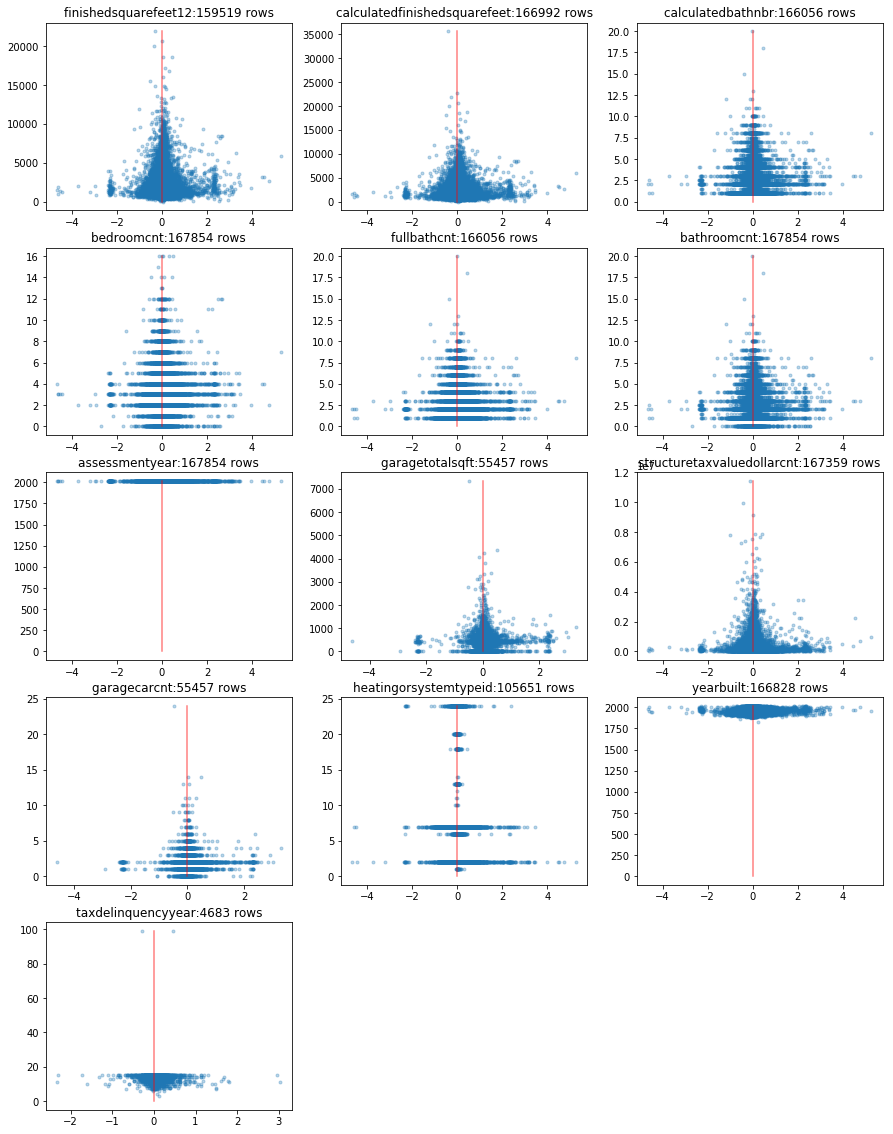

In [19]:
cols = corr_df_new.index

plt.figure(figsize=(15, 20))
yaxis = merged.logerror

for i in range(len(cols)):
    plt.subplot(5, 3, i + 1)
    xaxis = merged[cols[i]]
    plt.scatter(x=yaxis, y=xaxis, marker='.', alpha=.3)
    plt.plot([0, 0], [0, xaxis.max()], color='r', alpha=.5)
    plt.title(cols[i] + ':'+ str(int(xaxis.describe()[0])) + ' rows')

Zillow did a good job with these data. We can hardly see any trend in any of the plots above. If we use a restrict confidence level (e.g. 95%), we will probably not get anything significantly. However it is worth noticing that the distributions are not assymetrical and positively skewned, which is consistent with the positive skewness we observed earlier in the histogram of logerrors.

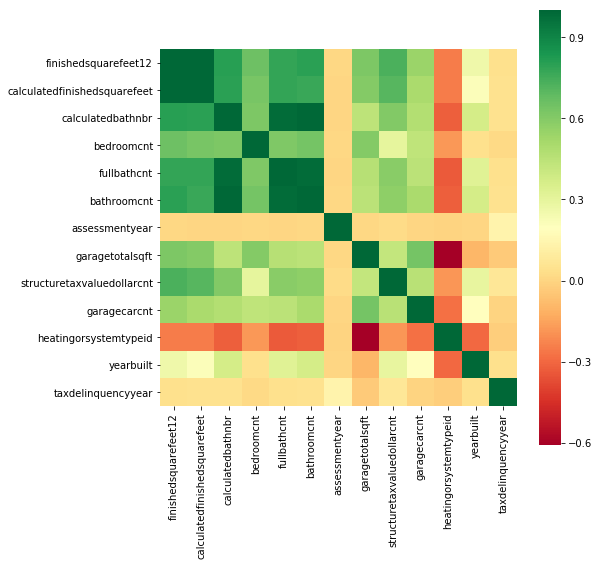

In [20]:
plt.figure(figsize=(8, 8))
sns.heatmap(merged[cols].corr(), square=True, cmap='RdYlGn')

#### Geographic features

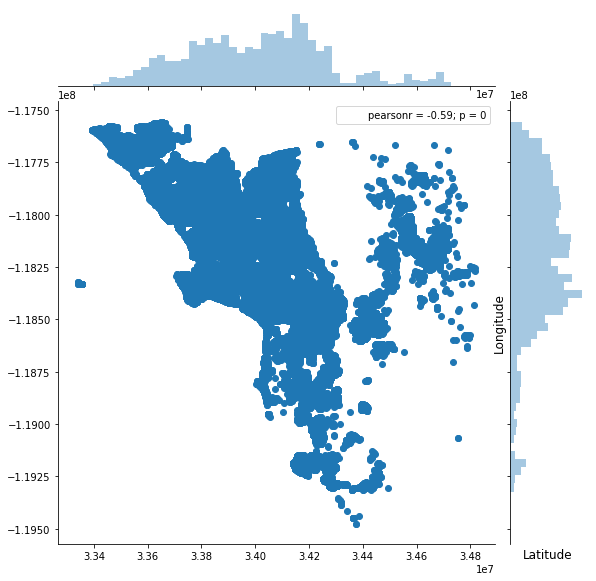

In [21]:
plt.figure(figsize=(10,10))
sns.jointplot(x=merged.latitude.values, y=merged.longitude.values, size=8)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

It make sense because we are provided with a full list of real estate properties in three counties (Los Angeles, Orange and Ventura, California) data in 2016 and Q1-Q3 2017. The plot above does look like gulf of LA. The blue dot to the left is probably some property in Channel Island.